In [4]:
# module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import torch
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.optim.lr_scheduler as lr_scheduler


In [5]:
import os

folder_path = 'C:/Users/quiet/Documents/jupyter/CS240/NSL-KDD'
#folder_path = '/content/drive/MyDrive/CS240/NSL-KDD'
#files = os.listdir(folder_path)

train_file = 'KDDTrain+.txt'
train_path = os.path.join(folder_path, train_file)
data_train = pd.read_csv(train_path)
# data_train.head()

test_file = 'KDDTest+.txt'
test_path = os.path.join(folder_path, test_file)
data_test = pd.read_csv(test_path)

print("Length of training set: ", len(data_train))
print("Length of testing set: ", len(data_test))

Length of training set:  125972
Length of testing set:  22543


In [6]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack','level'])
data_train.columns = columns
data_test.columns = columns

In [7]:
# map normal to 0, all attacks to 1
is_attack = data_train.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = data_test.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
data_train['attack_flag'] = is_attack
data_test['attack_flag'] = test_attack

# view the result
#data.head()

In [8]:
# lists to hold our attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
U2R = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
Sybil = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','U2R','Sybil']

# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in U2R:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in Sybil:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0

    return attack_type

# map the data and join to the data set
attack_map = data_train.attack.apply(map_attack)
data_train['attack_map'] = attack_map

test_attack_map = data_test.attack.apply(map_attack)
data_test['attack_map'] = test_attack_map

In [9]:
df = pd.concat([data_train, data_test])
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1,1


In [10]:
df_cat = df.select_dtypes(exclude=[np.number])
print(df_cat.columns)
for feature in df_cat.columns:
    df[feature] = LabelEncoder().fit_transform(df[feature])

Index(['protocol_type', 'service', 'flag', 'attack'], dtype='object')


In [11]:
import numpy as np

# Set the threshold for correlation
threshold = 0.95

corr_matrix = df.corr()
# Find the highly correlated variables
correlated_vars = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            correlated_vars.add((colname_j))
            print(f"Correlation between {colname_i} and {colname_j}: {corr_matrix.iloc[i, j]}")

# Print the number of highly correlated pairs
print("Number of highly correlated pairs:", len(correlated_vars))
print(correlated_vars)

Correlation between num_compromised and num_root: 0.9987247769091253
Correlation between serror_rate and srv_serror_rate: 0.9915070293624476
Correlation between serror_rate and dst_host_serror_rate: 0.9746961375901955
Correlation between serror_rate and dst_host_srv_serror_rate: 0.9760303434617954
Correlation between srv_serror_rate and dst_host_serror_rate: 0.9708018218887585
Correlation between srv_serror_rate and dst_host_srv_serror_rate: 0.9819823619122965
Correlation between rerror_rate and srv_rerror_rate: 0.9860945327614858
Correlation between rerror_rate and dst_host_srv_rerror_rate: 0.9573561564434296
Correlation between srv_rerror_rate and dst_host_srv_rerror_rate: 0.9656048075698501
Correlation between dst_host_serror_rate and dst_host_srv_serror_rate: 0.9828120697026873
Number of highly correlated pairs: 6
{'srv_serror_rate', 'srv_rerror_rate', 'dst_host_serror_rate', 'num_root', 'dst_host_srv_rerror_rate', 'dst_host_srv_serror_rate'}


In [12]:
df = df.drop(columns=correlated_vars)
fruitydf = df.sample(n=1000, random_state=42)
infogain = df.copy()

In [13]:
infogain.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_rerror_rate,attack,level,attack_flag,attack_map
0,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.0,16,15,0,0
1,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,0.0,14,19,1,1
2,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.0,16,21,0,0
3,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.0,16,21,0,0
4,0,1,49,1,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,1.0,14,21,1,1


In [14]:
X = df.drop(columns=['attack', 'level', 'attack_flag', 'attack_map'])
feature_list = list(X.columns)
X = np.array(X)
y = df['attack_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [15]:
X_train

array([[0.0e+00, 1.0e+00, 2.4e+01, ..., 1.0e-02, 1.0e-02, 0.0e+00],
       [0.0e+00, 1.0e+00, 4.9e+01, ..., 0.0e+00, 0.0e+00, 1.0e+00],
       [0.0e+00, 1.0e+00, 4.9e+01, ..., 0.0e+00, 0.0e+00, 0.0e+00],
       ...,
       [0.0e+00, 2.0e+00, 1.2e+01, ..., 1.0e-02, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.0e+00, 2.4e+01, ..., 0.0e+00, 0.0e+00, 9.9e-01],
       [0.0e+00, 1.0e+00, 5.1e+01, ..., 0.0e+00, 0.0e+00, 1.0e+00]])

In [15]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

information_gain = mutual_info_classif(X_train, y_train)

num_selected_features = 6
selected_features_indices = information_gain.argsort()[-num_selected_features:]
selected_features = X_train[:, selected_features_indices]


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(selected_features, y_train)

X_test_selected = X_test[:, selected_features_indices]
y_pred = clf.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Selected Features Indices:", selected_features_indices)
for i in selected_features_indices:
    print(f"index {i}, {feature_list[i]}")

Accuracy: 0.9918863414469918
Selected Features Indices: [26 25  3  2  5  4]
index 26, diff_srv_rate
index 25, same_srv_rate
index 3, flag
index 2, service
index 5, dst_bytes
index 4, src_bytes


In [16]:
selected_features_indices = [i for i in selected_features_indices if i != 3]
for i in selected_features_indices:
    print(f"index {i}, {feature_list[i]}")

index 26, diff_srv_rate
index 25, same_srv_rate
index 2, service
index 5, dst_bytes
index 4, src_bytes


In [17]:
X_train_infogain = X_train[:, selected_features_indices]
X_test_infogain = X_test[:, selected_features_indices]

In [18]:
X_train_infogain[:,0]

array([0.06, 0.05, 0.6 , ..., 1.  , 0.06, 0.  ])

In [19]:
scaler = StandardScaler().fit(X_train_infogain)
X_train_infogain = scaler.transform(X_train_infogain)
X_test_infogain = scaler.transform(X_test_infogain)

In [20]:
print(X_train_infogain.shape)

(118812, 5)


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.optim.lr_scheduler as lr_scheduler

# Define your neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, 5)
        self.fc5 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [22]:
# Define input dimension based on the number of selected features
input_dim_infogain = X_train_infogain.shape[1]
batch_size = 64
epochs = 50

# Standardize the selected features
#scaler = StandardScaler()
#X_train_infogain = scaler.fit_transform(X_train_infogain)
#X_test_infogain = scaler.transform(X_test_infogain)


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert your data to PyTorch tensors and move to GPU
X_train_tensor_infogain = torch.FloatTensor(X_train_infogain).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
X_test_tensor_infogain = torch.FloatTensor(X_test_infogain).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)

# Move the model to GPU
model_selected = NeuralNetwork(input_dim_infogain).to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_selected.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Define your dataloaders
train_dataset_infogain = TensorDataset(X_train_tensor_infogain, y_train_tensor)
train_loader_infogain = DataLoader(train_dataset_infogain, batch_size=batch_size, shuffle=True)

# Train your model
from tqdm import tqdm

# Train your model
total_batches = len(train_loader_infogain)
# Define early stopping parameters
early_stopping_rounds = 5
best_val_loss = float('inf')
best_epoch = 0
early_stopping_counter = 0

# Train your model
print("Using device: ", device)
for epoch in range(epochs):
    running_loss = 0.0
    val_loss = 0.0
    with tqdm(total=total_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for i, (inputs, targets) in enumerate(train_loader_infogain):
            optimizer.zero_grad()
            outputs = model_selected(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss / (i+1)})
            pbar.update(1)

        # Calculate validation loss
        with torch.no_grad():
            test_outputs = model_selected(X_test_tensor_infogain)
            val_loss = criterion(test_outputs, y_test_tensor)
            print(f"Train loss: {running_loss/(i+1)} Validation loss : {val_loss}")
            scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_rounds:
                print(f'Early stopping triggered! No improvement in validation loss for {early_stopping_rounds} consecutive epochs.')
                break

print('Training completed!')


# Evaluate your model
with torch.no_grad():
    train_outputs = model_selected(X_train_tensor_infogain)
    train_loss = criterion(train_outputs, y_train_tensor)
    train_acc = (train_outputs.argmax(dim=1) == y_train_tensor).float().mean()

    test_outputs = model_selected(X_test_tensor_infogain)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_acc = (test_outputs.argmax(dim=1) == y_test_tensor).float().mean()

print(f'Train: Loss: {train_loss.item()}, Accuracy: {train_acc.item()}')
print(f'Validation: Loss: {test_loss.item()}, Accuracy: {test_acc.item()}')
print(f'Best Validation Loss: {best_val_loss.item()} at Epoch {best_epoch+1}')


Using device:  cuda


Epoch 1/50: 100%|██████████| 1857/1857 [00:17<00:00, 106.42batch/s, loss=0.308]


Train loss: 0.3083482432947983 Validation loss : 0.2282041311264038


Epoch 2/50: 100%|██████████| 1857/1857 [00:17<00:00, 106.25batch/s, loss=0.216]


Train loss: 0.21562649206522658 Validation loss : 0.20414260029792786


Epoch 3/50: 100%|██████████| 1857/1857 [00:17<00:00, 108.51batch/s, loss=0.201]


Train loss: 0.2008014468994748 Validation loss : 0.18799428641796112


Epoch 4/50: 100%|██████████| 1857/1857 [00:17<00:00, 104.84batch/s, loss=0.189]


Train loss: 0.18874786702808702 Validation loss : 0.18796052038669586


Epoch 5/50: 100%|██████████| 1857/1857 [00:17<00:00, 106.56batch/s, loss=0.175]


Train loss: 0.1753480280290609 Validation loss : 0.16919481754302979


Epoch 6/50: 100%|██████████| 1857/1857 [00:17<00:00, 107.47batch/s, loss=0.168]


Train loss: 0.16841247593948902 Validation loss : 0.16135309636592865


Epoch 7/50: 100%|██████████| 1857/1857 [00:17<00:00, 106.24batch/s, loss=0.167]


Train loss: 0.16659286617831512 Validation loss : 0.16513469815254211


Epoch 8/50: 100%|██████████| 1857/1857 [00:16<00:00, 109.61batch/s, loss=0.164]


Train loss: 0.16368306993808263 Validation loss : 0.15665388107299805


Epoch 9/50: 100%|██████████| 1857/1857 [00:17<00:00, 105.67batch/s, loss=0.163]


Train loss: 0.16301566176116467 Validation loss : 0.1569589525461197


Epoch 10/50: 100%|██████████| 1857/1857 [00:17<00:00, 106.94batch/s, loss=0.16] 


Train loss: 0.16038260204184904 Validation loss : 0.15435604751110077


Epoch 11/50: 100%|██████████| 1857/1857 [00:17<00:00, 107.18batch/s, loss=0.158]


Train loss: 0.157929972351785 Validation loss : 0.15160131454467773


Epoch 12/50: 100%|██████████| 1857/1857 [00:17<00:00, 107.53batch/s, loss=0.155]


Train loss: 0.15535901317761094 Validation loss : 0.1545291543006897


Epoch 13/50: 100%|██████████| 1857/1857 [00:17<00:00, 106.25batch/s, loss=0.156]


Train loss: 0.1564525106493494 Validation loss : 0.15079373121261597


Epoch 14/50: 100%|██████████| 1857/1857 [00:17<00:00, 106.29batch/s, loss=0.153]


Train loss: 0.1534852869056394 Validation loss : 0.14572091400623322


Epoch 15/50: 100%|██████████| 1857/1857 [00:17<00:00, 107.61batch/s, loss=0.153]


Train loss: 0.1533085621520275 Validation loss : 0.1484208106994629


Epoch 16/50: 100%|██████████| 1857/1857 [00:17<00:00, 104.15batch/s, loss=0.152]


Train loss: 0.15182332873874027 Validation loss : 0.15030339360237122


Epoch 17/50: 100%|██████████| 1857/1857 [00:17<00:00, 106.03batch/s, loss=0.151]


Train loss: 0.1507687929999655 Validation loss : 0.14464180171489716


Epoch 18/50: 100%|██████████| 1857/1857 [00:17<00:00, 106.33batch/s, loss=0.15] 


Train loss: 0.15049512605907522 Validation loss : 0.14352543652057648


Epoch 19/50: 100%|██████████| 1857/1857 [00:17<00:00, 104.81batch/s, loss=0.149]


Train loss: 0.14871324183630988 Validation loss : 0.1484522521495819


Epoch 20/50: 100%|██████████| 1857/1857 [00:17<00:00, 105.44batch/s, loss=0.148]


Train loss: 0.14817022469735266 Validation loss : 0.14220337569713593


Epoch 21/50: 100%|██████████| 1857/1857 [00:17<00:00, 104.65batch/s, loss=0.147]


Train loss: 0.1474312983862514 Validation loss : 0.15398746728897095


Epoch 22/50: 100%|██████████| 1857/1857 [00:17<00:00, 105.08batch/s, loss=0.148]


Train loss: 0.14803881782237951 Validation loss : 0.14554578065872192


Epoch 23/50: 100%|██████████| 1857/1857 [00:17<00:00, 107.25batch/s, loss=0.146]


Train loss: 0.14647063002688435 Validation loss : 0.14655129611492157


Epoch 24/50: 100%|██████████| 1857/1857 [00:18<00:00, 102.95batch/s, loss=0.145]


Train loss: 0.14525294580030937 Validation loss : 0.15061570703983307


Epoch 25/50: 100%|██████████| 1857/1857 [00:17<00:00, 106.58batch/s, loss=0.141]


Train loss: 0.1411950298809177 Validation loss : 0.13778580725193024


Epoch 26/50: 100%|██████████| 1857/1857 [00:17<00:00, 106.75batch/s, loss=0.141]


Train loss: 0.1406854916229547 Validation loss : 0.13936525583267212


Epoch 27/50: 100%|██████████| 1857/1857 [00:16<00:00, 111.86batch/s, loss=0.14] 


Train loss: 0.139863201180813 Validation loss : 0.13587631285190582


Epoch 28/50: 100%|██████████| 1857/1857 [00:17<00:00, 108.45batch/s, loss=0.139]


Train loss: 0.13936170987588267 Validation loss : 0.14806687831878662


Epoch 29/50: 100%|██████████| 1857/1857 [00:17<00:00, 107.15batch/s, loss=0.139]


Train loss: 0.13919495057874332 Validation loss : 0.13518860936164856


Epoch 30/50: 100%|██████████| 1857/1857 [00:17<00:00, 108.25batch/s, loss=0.139]


Train loss: 0.13862881319588335 Validation loss : 0.13609908521175385


Epoch 31/50: 100%|██████████| 1857/1857 [00:18<00:00, 102.94batch/s, loss=0.139]


Train loss: 0.13861704281118523 Validation loss : 0.13737434148788452


Epoch 32/50: 100%|██████████| 1857/1857 [00:17<00:00, 103.37batch/s, loss=0.138]


Train loss: 0.13792114955607318 Validation loss : 0.1402791440486908


Epoch 33/50: 100%|██████████| 1857/1857 [00:17<00:00, 104.37batch/s, loss=0.138]


Train loss: 0.13759502578540778 Validation loss : 0.1349736452102661


Epoch 34/50: 100%|██████████| 1857/1857 [00:17<00:00, 105.38batch/s, loss=0.137]


Train loss: 0.137133105676551 Validation loss : 0.13469015061855316


Epoch 35/50: 100%|██████████| 1857/1857 [00:17<00:00, 105.34batch/s, loss=0.137]


Train loss: 0.1366203202332902 Validation loss : 0.13449330627918243


Epoch 36/50: 100%|██████████| 1857/1857 [00:17<00:00, 106.11batch/s, loss=0.137]


Train loss: 0.13656653988129455 Validation loss : 0.13512872159481049


Epoch 37/50: 100%|██████████| 1857/1857 [00:17<00:00, 106.60batch/s, loss=0.137]


Train loss: 0.13659881037701568 Validation loss : 0.13316932320594788


Epoch 38/50: 100%|██████████| 1857/1857 [00:17<00:00, 109.05batch/s, loss=0.136]


Train loss: 0.13637691736421922 Validation loss : 0.1331242322921753


Epoch 39/50: 100%|██████████| 1857/1857 [00:16<00:00, 110.04batch/s, loss=0.136]


Train loss: 0.13568299791214444 Validation loss : 0.13121812045574188


Epoch 40/50: 100%|██████████| 1857/1857 [00:17<00:00, 108.76batch/s, loss=0.136]


Train loss: 0.13573429951575666 Validation loss : 0.13321876525878906


Epoch 41/50: 100%|██████████| 1857/1857 [00:16<00:00, 109.82batch/s, loss=0.135]


Train loss: 0.13453094941986685 Validation loss : 0.1312158703804016


Epoch 42/50: 100%|██████████| 1857/1857 [00:16<00:00, 112.55batch/s, loss=0.135]


Train loss: 0.13510440067650412 Validation loss : 0.13138288259506226


Epoch 43/50: 100%|██████████| 1857/1857 [00:16<00:00, 113.93batch/s, loss=0.135]


Train loss: 0.13498870510353186 Validation loss : 0.1314147710800171


Epoch 44/50: 100%|██████████| 1857/1857 [00:17<00:00, 109.21batch/s, loss=0.132]


Train loss: 0.13184730894963909 Validation loss : 0.12870454788208008


Epoch 45/50: 100%|██████████| 1857/1857 [00:17<00:00, 107.88batch/s, loss=0.131]


Train loss: 0.1312996506717058 Validation loss : 0.1302063763141632


Epoch 46/50: 100%|██████████| 1857/1857 [00:17<00:00, 108.92batch/s, loss=0.131]


Train loss: 0.13120499435826277 Validation loss : 0.1300160437822342


Epoch 47/50: 100%|██████████| 1857/1857 [00:17<00:00, 108.12batch/s, loss=0.131]


Train loss: 0.1308759581598548 Validation loss : 0.12825758755207062


Epoch 48/50: 100%|██████████| 1857/1857 [00:16<00:00, 110.05batch/s, loss=0.131]


Train loss: 0.13063607239763728 Validation loss : 0.13130690157413483


Epoch 49/50: 100%|██████████| 1857/1857 [00:16<00:00, 110.36batch/s, loss=0.13] 


Train loss: 0.13032102479018154 Validation loss : 0.12821902334690094


Epoch 50/50: 100%|██████████| 1857/1857 [00:16<00:00, 111.05batch/s, loss=0.13] 


Train loss: 0.13009137609009627 Validation loss : 0.1306314766407013
Training completed!
Train: Loss: 0.13323406875133514, Accuracy: 0.9501229524612427
Validation: Loss: 0.1306314766407013, Accuracy: 0.9514191150665283
Best Validation Loss: 0.12821902334690094 at Epoch 49


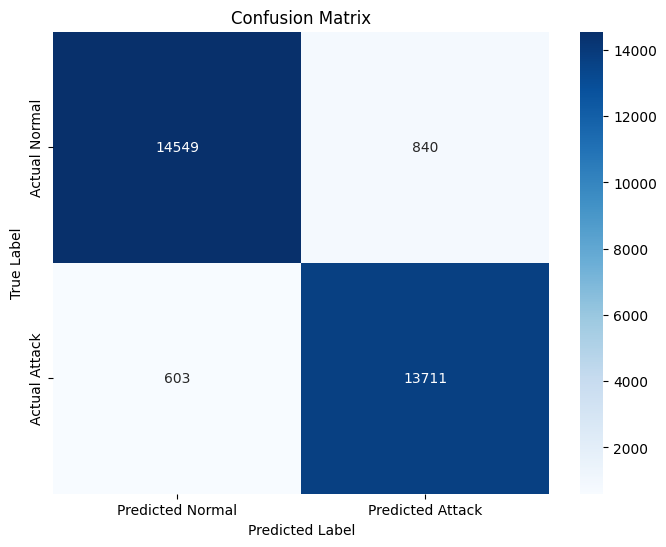

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions on test data
with torch.no_grad():
    test_outputs = model_selected(X_test_tensor_infogain)
    y_pred = test_outputs.argmax(dim=1).cpu().numpy()

# Convert true labels tensor to numpy array
y_true = y_test_tensor.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define labels for heatmap
xticklabels = ['Predicted Normal', 'Predicted Attack']
yticklabels = ['Actual Normal', 'Actual Attack']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Calculate false positives and false negatives from the test set confusion matrix
false_positives = cm[0, 1]  # Predicted 1, but actually 0
false_negatives = cm[1, 0]  # Predicted 0, but actually 1

# Calculate total actual positives and total actual negatives
total_positives = np.sum(cm[1, :])  # Total actual positives
total_negatives = np.sum(cm[0, :])  # Total actual negatives

# Calculate percentages
false_positive_rate = (false_positives / total_negatives) * 100
false_negative_rate = (false_negatives / total_positives) * 100

print("False Positive Rate:", false_positive_rate, "%")
print("False Negative Rate:", false_negative_rate, "%")

False Positive Rate: 5.458444343362142 %
False Negative Rate: 4.21265893530809 %
